<a href="https://colab.research.google.com/github/giorgosstath16/AIDL_03/blob/main/%CE%91%CE%BD%CF%84%CE%AF%CE%B3%CF%81%CE%B1%CF%86%CE%BF_AIC_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL
from PIL import Image
import cv2, os
from tqdm.notebook import tqdm

In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#load the aircrafts dataset from kaggle
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
!kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset

%ls

100% 6.25G/6.26G [01:27<00:00, 81.5MB/s]
100% 6.26G/6.26G [01:27<00:00, 76.5MB/s]
kaggle.json  militaryaircraftdetectiondataset.zip


In [ ]:
!unzip \militaryaircraftdetectiondataset.zip  -d \militaryaircraftdetectiondataset && rm *.zip  

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: militaryaircraftdetectiondataset/dataset/9a90836057ab9a95536df623df0d1389.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9a90836057ab9a95536df623df0d1389.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/9aaa81880d1d37671d18cd9aca0c8120.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9aaa81880d1d37671d18cd9aca0c8120.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/9aabd19f8037b09cdbdf90940d404249.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9aabd19f8037b09cdbdf90940d404249.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/9aaddcc6bb1c52b07c97855a7a0aa5e0.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9aaddcc6bb1c52b07c97855a7a0aa5e0.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/9aba7d01b95e9bd71a637586d7bae1e5.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9aba7d01b95e9bd71a637586d7bae1e5.jpg  
  inflating: mi

In [ ]:
#create a pd dataframe w/ images and its labels in csv
path = "/content/drive/MyDrive/Kaggle/militaryaircraftdetectiondataset/dataset/"
images = glob.glob(path+ '*.jpg')
annot = []
for img in images: annot.append(img.replace('jpg','csv'))
df = pd.DataFrame({'image':images, 'annot':annot})
#preview
df.head()

,image,annot
0,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...
1,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...
2,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...
3,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...
4,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...


In [ ]:
#plot some dataset images to preview
def show_samples(n=None):
  img_index = list(np.round((np.random.random(n))*len(df)))
  fig, ax = plt.subplots(1,n,figsize=(20,20))
  i=0
  for idx in img_index:
    img = df.image.values[int(idx)]
    img = Image.open(img)
    ax[i].imshow(img)
    i +=1
  plt.show()
  return None    

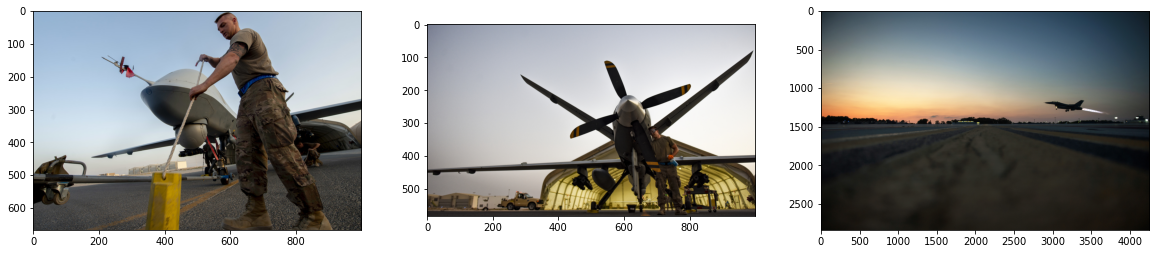

In [ ]:
show_samples(n=3)

In [ ]:
dataset = pd.DataFrame(columns = ['img','label'])
dataset.head()

,img,label


In [ ]:
for i in tqdm(range(len(df))):
    annot = pd.read_csv(df.annot.values[i])
    label = annot['class'].values
    img = str(df.image.values[i])
    inter_df = pd.DataFrame({'img':img,'label':label})
    dataset = dataset.append(inter_df)

  0%|          | 0/6178 [00:00<?, ?it/s]

In [ ]:
dataset.img.size

10658

In [ ]:
dataset.label.nunique()

40

In [ ]:
#shuffle entire DataFrame and reset index
sh_ds = dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
sh_ds.head()

,img,label
0,/content/drive/MyDrive/Kaggle/militaryaircraft...,F4
1,/content/drive/MyDrive/Kaggle/militaryaircraft...,F4
2,/content/drive/MyDrive/Kaggle/militaryaircraft...,Tu95
3,/content/drive/MyDrive/Kaggle/militaryaircraft...,Rafale
4,/content/drive/MyDrive/Kaggle/militaryaircraft...,C130


In [ ]:
images = []
labels = []
size = 128,128 

for image in dataset.img:  
  temp_img = cv2.imread(image)
  temp_img = cv2.resize(temp_img, size)
  images.append(temp_img)

for aircraft in dataset.label:
  labels.append(aircraft)

labels_np = np.asarray(labels)
labels_np = labels_np.reshape(-1,1)
# define one hot encoding
encoder = OneHotEncoder(drop=None, sparse=False)
# transform data
onehot = encoder.fit_transform(labels_np)

images = np.array(images)
images = images.astype('float32')/255.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, onehot, test_size = 0.2, random_state = 3)

In [ ]:
print('Loaded', len(x_train),'images for training,','Train data shape =', x_train.shape)
print('Loaded', len(x_test),'images for testing','Test data shape =', x_test.shape)
print('Loaded', len(y_train),'images for training,','Train data shape =', y_train.shape)
print('Loaded', len(y_test),'images for testing','Test data shape =', y_test.shape)

Loaded 8526 images for training, Train data shape = (8526, 128, 128, 3)
Loaded 2132 images for testing Test data shape = (2132, 128, 128, 3)
Loaded 8526 images for training, Train data shape = (8526, 40)
Loaded 2132 images for testing Test data shape = (2132, 40)


In [ ]:
classes = dataset.label.nunique()
batch = 256
epochs = 40
learning_rate = 0.0001

In [ ]:
# build model architecture
model = Sequential()
model.add(VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3)))
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(40, activation='softmax'))

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa

In [ ]:
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [ ]:
adam = Adam(lr=learning_rate)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_split=0.1, shuffle = True, verbose=2, callbacks=[save_model, tqdm_callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training:   0%|           0/40 ETA: ?s,  ?epochs/s

Epoch 1/40


0/30           ETA: ?s - 

Epoch 1/40

Epoch 1: val_loss improved from inf to 3.31489, saving model to best_model.h5
30/30 - 90s - loss: 3.5005 - accuracy: 0.0842 - val_loss: 3.3149 - val_accuracy: 0.1219 - 90s/epoch - 3s/step
Epoch 2/40


0/30           ETA: ?s - 

Epoch 2/40

Epoch 2: val_loss improved from 3.31489 to 2.90974, saving model to best_model.h5
30/30 - 43s - loss: 2.9546 - accuracy: 0.2282 - val_loss: 2.9097 - val_accuracy: 0.2556 - 43s/epoch - 1s/step
Epoch 3/40


0/30           ETA: ?s - 

Epoch 3/40

Epoch 3: val_loss improved from 2.90974 to 2.58308, saving model to best_model.h5
30/30 - 43s - loss: 2.3103 - accuracy: 0.4077 - val_loss: 2.5831 - val_accuracy: 0.3306 - 43s/epoch - 1s/step
Epoch 4/40


0/30           ETA: ?s - 

Epoch 4/40

Epoch 4: val_loss improved from 2.58308 to 2.36733, saving model to best_model.h5
30/30 - 42s - loss: 1.7441 - accuracy: 0.5771 - val_loss: 2.3673 - val_accuracy: 0.3892 - 42s/epoch - 1s/step
Epoch 5/40


0/30           ETA: ?s - 

Epoch 5/40

Epoch 5: val_loss improved from 2.36733 to 2.18822, saving model to best_model.h5
30/30 - 42s - loss: 1.3317 - accuracy: 0.6991 - val_loss: 2.1882 - val_accuracy: 0.4525 - 42s/epoch - 1s/step
Epoch 6/40


0/30           ETA: ?s - 

Epoch 6/40

Epoch 6: val_loss improved from 2.18822 to 2.12588, saving model to best_model.h5
30/30 - 42s - loss: 0.9963 - accuracy: 0.7890 - val_loss: 2.1259 - val_accuracy: 0.4607 - 42s/epoch - 1s/step
Epoch 7/40


0/30           ETA: ?s - 

Epoch 7/40

Epoch 7: val_loss improved from 2.12588 to 2.06530, saving model to best_model.h5
30/30 - 42s - loss: 0.7546 - accuracy: 0.8479 - val_loss: 2.0653 - val_accuracy: 0.4701 - 42s/epoch - 1s/step
Epoch 8/40


0/30           ETA: ?s - 

Epoch 8/40

Epoch 8: val_loss improved from 2.06530 to 2.01625, saving model to best_model.h5
30/30 - 42s - loss: 0.5903 - accuracy: 0.8764 - val_loss: 2.0163 - val_accuracy: 0.4795 - 42s/epoch - 1s/step
Epoch 9/40


0/30           ETA: ?s - 

Epoch 9/40

Epoch 9: val_loss improved from 2.01625 to 2.00180, saving model to best_model.h5
30/30 - 42s - loss: 0.4759 - accuracy: 0.8884 - val_loss: 2.0018 - val_accuracy: 0.4994 - 42s/epoch - 1s/step
Epoch 10/40


0/30           ETA: ?s - 

Epoch 10/40

Epoch 10: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.4050 - accuracy: 0.8927 - val_loss: 2.0149 - val_accuracy: 0.4994 - 40s/epoch - 1s/step
Epoch 11/40


0/30           ETA: ?s - 

Epoch 11/40

Epoch 11: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.3626 - accuracy: 0.8926 - val_loss: 2.0376 - val_accuracy: 0.4982 - 40s/epoch - 1s/step
Epoch 12/40


0/30           ETA: ?s - 

Epoch 12/40

Epoch 12: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.3312 - accuracy: 0.8942 - val_loss: 2.0125 - val_accuracy: 0.5053 - 40s/epoch - 1s/step
Epoch 13/40


0/30           ETA: ?s - 

Epoch 13/40

Epoch 13: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2995 - accuracy: 0.8940 - val_loss: 2.0270 - val_accuracy: 0.4853 - 40s/epoch - 1s/step
Epoch 14/40


0/30           ETA: ?s - 

Epoch 14/40

Epoch 14: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2855 - accuracy: 0.8993 - val_loss: 2.0402 - val_accuracy: 0.4994 - 40s/epoch - 1s/step
Epoch 15/40


0/30           ETA: ?s - 

Epoch 15/40

Epoch 15: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2757 - accuracy: 0.8955 - val_loss: 2.0267 - val_accuracy: 0.4900 - 40s/epoch - 1s/step
Epoch 16/40


0/30           ETA: ?s - 

Epoch 16/40

Epoch 16: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2627 - accuracy: 0.8968 - val_loss: 2.0622 - val_accuracy: 0.5018 - 40s/epoch - 1s/step
Epoch 17/40


0/30           ETA: ?s - 

Epoch 17/40

Epoch 17: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2520 - accuracy: 0.8950 - val_loss: 2.0491 - val_accuracy: 0.4982 - 40s/epoch - 1s/step
Epoch 18/40


0/30           ETA: ?s - 

Epoch 18/40

Epoch 18: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2461 - accuracy: 0.8959 - val_loss: 2.0391 - val_accuracy: 0.4936 - 40s/epoch - 1s/step
Epoch 19/40


0/30           ETA: ?s - 

Epoch 19/40

Epoch 19: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2402 - accuracy: 0.8977 - val_loss: 2.0616 - val_accuracy: 0.5064 - 40s/epoch - 1s/step
Epoch 20/40


0/30           ETA: ?s - 

Epoch 20/40

Epoch 20: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2362 - accuracy: 0.8970 - val_loss: 2.0584 - val_accuracy: 0.5006 - 40s/epoch - 1s/step
Epoch 21/40


0/30           ETA: ?s - 

Epoch 21/40

Epoch 21: val_loss did not improve from 2.00180
30/30 - 39s - loss: 0.2299 - accuracy: 0.8968 - val_loss: 2.0519 - val_accuracy: 0.4936 - 39s/epoch - 1s/step
Epoch 22/40


0/30           ETA: ?s - 

Epoch 22/40

Epoch 22: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2248 - accuracy: 0.8983 - val_loss: 2.0500 - val_accuracy: 0.4982 - 40s/epoch - 1s/step
Epoch 23/40


0/30           ETA: ?s - 

Epoch 23/40

Epoch 23: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2222 - accuracy: 0.8955 - val_loss: 2.0814 - val_accuracy: 0.5006 - 40s/epoch - 1s/step
Epoch 24/40


0/30           ETA: ?s - 

Epoch 24/40

Epoch 24: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2176 - accuracy: 0.8990 - val_loss: 2.1102 - val_accuracy: 0.4959 - 40s/epoch - 1s/step
Epoch 25/40


0/30           ETA: ?s - 

Epoch 25/40

Epoch 25: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2162 - accuracy: 0.8946 - val_loss: 2.0761 - val_accuracy: 0.5041 - 40s/epoch - 1s/step
Epoch 26/40


0/30           ETA: ?s - 

Epoch 26/40

Epoch 26: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2168 - accuracy: 0.8976 - val_loss: 2.1005 - val_accuracy: 0.5018 - 40s/epoch - 1s/step
Epoch 27/40


0/30           ETA: ?s - 

Epoch 27/40

Epoch 27: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2118 - accuracy: 0.8976 - val_loss: 2.0919 - val_accuracy: 0.5018 - 40s/epoch - 1s/step
Epoch 28/40


0/30           ETA: ?s - 

Epoch 28/40

Epoch 28: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2124 - accuracy: 0.8961 - val_loss: 2.0809 - val_accuracy: 0.5147 - 40s/epoch - 1s/step
Epoch 29/40


0/30           ETA: ?s - 

Epoch 29/40

Epoch 29: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2080 - accuracy: 0.8942 - val_loss: 2.0754 - val_accuracy: 0.5053 - 40s/epoch - 1s/step
Epoch 30/40


0/30           ETA: ?s - 

Epoch 30/40

Epoch 30: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2034 - accuracy: 0.8965 - val_loss: 2.0916 - val_accuracy: 0.5123 - 40s/epoch - 1s/step
Epoch 31/40


0/30           ETA: ?s - 

Epoch 31/40

Epoch 31: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2012 - accuracy: 0.8965 - val_loss: 2.1193 - val_accuracy: 0.4924 - 40s/epoch - 1s/step
Epoch 32/40


0/30           ETA: ?s - 

Epoch 32/40

Epoch 32: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2016 - accuracy: 0.8987 - val_loss: 2.1093 - val_accuracy: 0.5088 - 40s/epoch - 1s/step
Epoch 33/40


0/30           ETA: ?s - 

Epoch 33/40

Epoch 33: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.2015 - accuracy: 0.8950 - val_loss: 2.1381 - val_accuracy: 0.5041 - 40s/epoch - 1s/step
Epoch 34/40


0/30           ETA: ?s - 

Epoch 34/40

Epoch 34: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.1976 - accuracy: 0.8967 - val_loss: 2.1340 - val_accuracy: 0.5018 - 40s/epoch - 1s/step
Epoch 35/40


0/30           ETA: ?s - 

Epoch 35/40

Epoch 35: val_loss did not improve from 2.00180
30/30 - 39s - loss: 0.1966 - accuracy: 0.8968 - val_loss: 2.1525 - val_accuracy: 0.5018 - 39s/epoch - 1s/step
Epoch 36/40


0/30           ETA: ?s - 

Epoch 36/40

Epoch 36: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.1975 - accuracy: 0.8972 - val_loss: 2.1131 - val_accuracy: 0.5029 - 40s/epoch - 1s/step
Epoch 37/40


0/30           ETA: ?s - 

Epoch 37/40

Epoch 37: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.1945 - accuracy: 0.8952 - val_loss: 2.1249 - val_accuracy: 0.5018 - 40s/epoch - 1s/step
Epoch 38/40


0/30           ETA: ?s - 

Epoch 38/40

Epoch 38: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.1916 - accuracy: 0.8961 - val_loss: 2.1163 - val_accuracy: 0.4994 - 40s/epoch - 1s/step
Epoch 39/40


0/30           ETA: ?s - 

Epoch 39/40

Epoch 39: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.1927 - accuracy: 0.8980 - val_loss: 2.1609 - val_accuracy: 0.5053 - 40s/epoch - 1s/step
Epoch 40/40


0/30           ETA: ?s - 

Epoch 40/40

Epoch 40: val_loss did not improve from 2.00180
30/30 - 40s - loss: 0.1934 - accuracy: 0.8978 - val_loss: 2.1600 - val_accuracy: 0.4877 - 40s/epoch - 1s/step


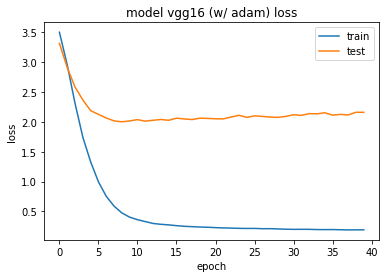

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model vgg16 (w/ adam) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

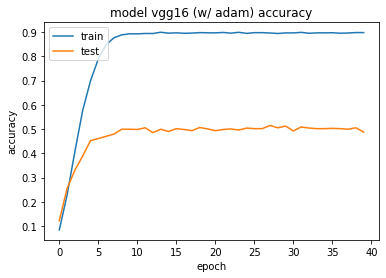

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model vgg16 (w/ adam) accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history.model.load_weights('best_model.h5')
np.mean(np.round(history.model.predict(x_test))==y_test)

0.9824343339587241

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import SGD

In [ ]:
# build model architecture
model2 = Sequential()
model2.add(ResNet50V2(weights='imagenet', include_top=False, input_shape=(128,128,3)))
model2.add(Flatten())
model2.add(Dense(1024, activation='sigmoid'))
model2.add(Dense(40, activation='softmax'))

In [ ]:
sgd = SGD(lr=0.0002)
save_model2 = ModelCheckpoint('best_model_2.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.1, shuffle = True, verbose=1, callbacks=[save_model2, tqdm_callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/30           ETA: ?s - 

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 4.0043 - accuracy: 0.0268
Epoch 1: val_loss improved from inf to 4.02063, saving model to best_model_2.h5
30/30 [==============================] - 66s 1s/step - loss: 4.0043 - accuracy: 0.0268 - val_loss: 4.0206 - val_accuracy: 0.0246
Epoch 2/100


0/30           ETA: ?s - 

Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 3.9218 - accuracy: 0.0292
Epoch 2: val_loss improved from 4.02063 to 3.94711, saving model to best_model_2.h5
30/30 [==============================] - 25s 848ms/step - loss: 3.9218 - accuracy: 0.0292 - val_loss: 3.9471 - val_accuracy: 0.0340
Epoch 3/100


0/30           ETA: ?s - 

Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 3.8542 - accuracy: 0.0302
Epoch 3: val_loss improved from 3.94711 to 3.89431, saving model to best_model_2.h5
30/30 [==============================] - 26s 879ms/step - loss: 3.8542 - accuracy: 0.0302 - val_loss: 3.8943 - val_accuracy: 0.0293
Epoch 4/100


0/30           ETA: ?s - 

Epoch 4/100
30/30 [==============================] - ETA: 0s - loss: 3.7899 - accuracy: 0.0369
Epoch 4: val_loss improved from 3.89431 to 3.84695, saving model to best_model_2.h5
30/30 [==============================] - 26s 879ms/step - loss: 3.7899 - accuracy: 0.0369 - val_loss: 3.8469 - val_accuracy: 0.0305
Epoch 5/100


0/30           ETA: ?s - 

Epoch 5/100
30/30 [==============================] - ETA: 0s - loss: 3.7328 - accuracy: 0.0443
Epoch 5: val_loss improved from 3.84695 to 3.80404, saving model to best_model_2.h5
30/30 [==============================] - 26s 854ms/step - loss: 3.7328 - accuracy: 0.0443 - val_loss: 3.8040 - val_accuracy: 0.0410
Epoch 6/100


0/30           ETA: ?s - 

Epoch 6/100
30/30 [==============================] - ETA: 0s - loss: 3.6835 - accuracy: 0.0584
Epoch 6: val_loss improved from 3.80404 to 3.76436, saving model to best_model_2.h5
30/30 [==============================] - 26s 871ms/step - loss: 3.6835 - accuracy: 0.0584 - val_loss: 3.7644 - val_accuracy: 0.0422
Epoch 7/100


0/30           ETA: ?s - 

Epoch 7/100
30/30 [==============================] - ETA: 0s - loss: 3.6431 - accuracy: 0.0731
Epoch 7: val_loss improved from 3.76436 to 3.72706, saving model to best_model_2.h5
30/30 [==============================] - 26s 862ms/step - loss: 3.6431 - accuracy: 0.0731 - val_loss: 3.7271 - val_accuracy: 0.0387
Epoch 8/100


0/30           ETA: ?s - 

Epoch 8/100
30/30 [==============================] - ETA: 0s - loss: 3.6016 - accuracy: 0.0829
Epoch 8: val_loss improved from 3.72706 to 3.69177, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 3.6016 - accuracy: 0.0829 - val_loss: 3.6918 - val_accuracy: 0.0563
Epoch 9/100


0/30           ETA: ?s - 

Epoch 9/100
30/30 [==============================] - ETA: 0s - loss: 3.5590 - accuracy: 0.0925
Epoch 9: val_loss improved from 3.69177 to 3.65908, saving model to best_model_2.h5
30/30 [==============================] - 26s 862ms/step - loss: 3.5590 - accuracy: 0.0925 - val_loss: 3.6591 - val_accuracy: 0.0598
Epoch 10/100


0/30           ETA: ?s - 

Epoch 10/100
30/30 [==============================] - ETA: 0s - loss: 3.5270 - accuracy: 0.1058
Epoch 10: val_loss improved from 3.65908 to 3.62809, saving model to best_model_2.h5
30/30 [==============================] - 26s 869ms/step - loss: 3.5270 - accuracy: 0.1058 - val_loss: 3.6281 - val_accuracy: 0.0727
Epoch 11/100


0/30           ETA: ?s - 

Epoch 11/100
30/30 [==============================] - ETA: 0s - loss: 3.4905 - accuracy: 0.1176
Epoch 11: val_loss improved from 3.62809 to 3.59711, saving model to best_model_2.h5
30/30 [==============================] - 26s 863ms/step - loss: 3.4905 - accuracy: 0.1176 - val_loss: 3.5971 - val_accuracy: 0.0891
Epoch 12/100


0/30           ETA: ?s - 

Epoch 12/100
30/30 [==============================] - ETA: 0s - loss: 3.4609 - accuracy: 0.1279
Epoch 12: val_loss improved from 3.59711 to 3.57057, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 3.4609 - accuracy: 0.1279 - val_loss: 3.5706 - val_accuracy: 0.0903
Epoch 13/100


0/30           ETA: ?s - 

Epoch 13/100
30/30 [==============================] - ETA: 0s - loss: 3.4319 - accuracy: 0.1359
Epoch 13: val_loss improved from 3.57057 to 3.54598, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 3.4319 - accuracy: 0.1359 - val_loss: 3.5460 - val_accuracy: 0.1055
Epoch 14/100


0/30           ETA: ?s - 

Epoch 14/100
30/30 [==============================] - ETA: 0s - loss: 3.4044 - accuracy: 0.1444
Epoch 14: val_loss improved from 3.54598 to 3.52026, saving model to best_model_2.h5
30/30 [==============================] - 28s 929ms/step - loss: 3.4044 - accuracy: 0.1444 - val_loss: 3.5203 - val_accuracy: 0.1114
Epoch 15/100


0/30           ETA: ?s - 

Epoch 15/100
30/30 [==============================] - ETA: 0s - loss: 3.3763 - accuracy: 0.1520
Epoch 15: val_loss improved from 3.52026 to 3.49837, saving model to best_model_2.h5
30/30 [==============================] - 26s 856ms/step - loss: 3.3763 - accuracy: 0.1520 - val_loss: 3.4984 - val_accuracy: 0.1266
Epoch 16/100


0/30           ETA: ?s - 

Epoch 16/100
30/30 [==============================] - ETA: 0s - loss: 3.3543 - accuracy: 0.1611
Epoch 16: val_loss improved from 3.49837 to 3.47929, saving model to best_model_2.h5
30/30 [==============================] - 26s 863ms/step - loss: 3.3543 - accuracy: 0.1611 - val_loss: 3.4793 - val_accuracy: 0.1325
Epoch 17/100


0/30           ETA: ?s - 

Epoch 17/100
30/30 [==============================] - ETA: 0s - loss: 3.3312 - accuracy: 0.1673
Epoch 17: val_loss improved from 3.47929 to 3.46151, saving model to best_model_2.h5
30/30 [==============================] - 26s 861ms/step - loss: 3.3312 - accuracy: 0.1673 - val_loss: 3.4615 - val_accuracy: 0.1360
Epoch 18/100


0/30           ETA: ?s - 

Epoch 18/100
30/30 [==============================] - ETA: 0s - loss: 3.3060 - accuracy: 0.1800
Epoch 18: val_loss improved from 3.46151 to 3.44743, saving model to best_model_2.h5
30/30 [==============================] - 26s 856ms/step - loss: 3.3060 - accuracy: 0.1800 - val_loss: 3.4474 - val_accuracy: 0.1407
Epoch 19/100


0/30           ETA: ?s - 

Epoch 19/100
30/30 [==============================] - ETA: 0s - loss: 3.2850 - accuracy: 0.1792
Epoch 19: val_loss improved from 3.44743 to 3.43003, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 3.2850 - accuracy: 0.1792 - val_loss: 3.4300 - val_accuracy: 0.1442
Epoch 20/100


0/30           ETA: ?s - 

Epoch 20/100
30/30 [==============================] - ETA: 0s - loss: 3.2646 - accuracy: 0.1881
Epoch 20: val_loss improved from 3.43003 to 3.41484, saving model to best_model_2.h5
30/30 [==============================] - 26s 865ms/step - loss: 3.2646 - accuracy: 0.1881 - val_loss: 3.4148 - val_accuracy: 0.1501
Epoch 21/100


0/30           ETA: ?s - 

Epoch 21/100
30/30 [==============================] - ETA: 0s - loss: 3.2424 - accuracy: 0.1955
Epoch 21: val_loss improved from 3.41484 to 3.40197, saving model to best_model_2.h5
30/30 [==============================] - 26s 867ms/step - loss: 3.2424 - accuracy: 0.1955 - val_loss: 3.4020 - val_accuracy: 0.1501
Epoch 22/100


0/30           ETA: ?s - 

Epoch 22/100
30/30 [==============================] - ETA: 0s - loss: 3.2238 - accuracy: 0.1994
Epoch 22: val_loss improved from 3.40197 to 3.38957, saving model to best_model_2.h5
30/30 [==============================] - 26s 856ms/step - loss: 3.2238 - accuracy: 0.1994 - val_loss: 3.3896 - val_accuracy: 0.1547
Epoch 23/100


0/30           ETA: ?s - 

Epoch 23/100
30/30 [==============================] - ETA: 0s - loss: 3.2040 - accuracy: 0.2067
Epoch 23: val_loss improved from 3.38957 to 3.37697, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 3.2040 - accuracy: 0.2067 - val_loss: 3.3770 - val_accuracy: 0.1594
Epoch 24/100


0/30           ETA: ?s - 

Epoch 24/100
30/30 [==============================] - ETA: 0s - loss: 3.1763 - accuracy: 0.2149
Epoch 24: val_loss improved from 3.37697 to 3.36526, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 3.1763 - accuracy: 0.2149 - val_loss: 3.3653 - val_accuracy: 0.1630
Epoch 25/100


0/30           ETA: ?s - 

Epoch 25/100
30/30 [==============================] - ETA: 0s - loss: 3.1679 - accuracy: 0.2213
Epoch 25: val_loss improved from 3.36526 to 3.35489, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 3.1679 - accuracy: 0.2213 - val_loss: 3.3549 - val_accuracy: 0.1676
Epoch 26/100


0/30           ETA: ?s - 

Epoch 26/100
30/30 [==============================] - ETA: 0s - loss: 3.1516 - accuracy: 0.2226
Epoch 26: val_loss improved from 3.35489 to 3.34265, saving model to best_model_2.h5
30/30 [==============================] - 26s 867ms/step - loss: 3.1516 - accuracy: 0.2226 - val_loss: 3.3427 - val_accuracy: 0.1688
Epoch 27/100


0/30           ETA: ?s - 

Epoch 27/100
30/30 [==============================] - ETA: 0s - loss: 3.1331 - accuracy: 0.2287
Epoch 27: val_loss improved from 3.34265 to 3.33131, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 3.1331 - accuracy: 0.2287 - val_loss: 3.3313 - val_accuracy: 0.1735
Epoch 28/100


0/30           ETA: ?s - 

Epoch 28/100
30/30 [==============================] - ETA: 0s - loss: 3.1108 - accuracy: 0.2376
Epoch 28: val_loss improved from 3.33131 to 3.32107, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 3.1108 - accuracy: 0.2376 - val_loss: 3.3211 - val_accuracy: 0.1770
Epoch 29/100


0/30           ETA: ?s - 

Epoch 29/100
30/30 [==============================] - ETA: 0s - loss: 3.0946 - accuracy: 0.2429
Epoch 29: val_loss improved from 3.32107 to 3.31073, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 3.0946 - accuracy: 0.2429 - val_loss: 3.3107 - val_accuracy: 0.1805
Epoch 30/100


0/30           ETA: ?s - 

Epoch 30/100
30/30 [==============================] - ETA: 0s - loss: 3.0781 - accuracy: 0.2468
Epoch 30: val_loss improved from 3.31073 to 3.30042, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 3.0781 - accuracy: 0.2468 - val_loss: 3.3004 - val_accuracy: 0.1852
Epoch 31/100


0/30           ETA: ?s - 

Epoch 31/100
30/30 [==============================] - ETA: 0s - loss: 3.0611 - accuracy: 0.2539
Epoch 31: val_loss improved from 3.30042 to 3.29049, saving model to best_model_2.h5
30/30 [==============================] - 26s 862ms/step - loss: 3.0611 - accuracy: 0.2539 - val_loss: 3.2905 - val_accuracy: 0.1876
Epoch 32/100


0/30           ETA: ?s - 

Epoch 32/100
30/30 [==============================] - ETA: 0s - loss: 3.0479 - accuracy: 0.2577
Epoch 32: val_loss improved from 3.29049 to 3.28050, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 3.0479 - accuracy: 0.2577 - val_loss: 3.2805 - val_accuracy: 0.1864
Epoch 33/100


0/30           ETA: ?s - 

Epoch 33/100
30/30 [==============================] - ETA: 0s - loss: 3.0247 - accuracy: 0.2638
Epoch 33: val_loss improved from 3.28050 to 3.27113, saving model to best_model_2.h5
30/30 [==============================] - 26s 855ms/step - loss: 3.0247 - accuracy: 0.2638 - val_loss: 3.2711 - val_accuracy: 0.1899
Epoch 34/100


0/30           ETA: ?s - 

Epoch 34/100
30/30 [==============================] - ETA: 0s - loss: 3.0160 - accuracy: 0.2715
Epoch 34: val_loss improved from 3.27113 to 3.26267, saving model to best_model_2.h5
30/30 [==============================] - 26s 862ms/step - loss: 3.0160 - accuracy: 0.2715 - val_loss: 3.2627 - val_accuracy: 0.1911
Epoch 35/100


0/30           ETA: ?s - 

Epoch 35/100
30/30 [==============================] - ETA: 0s - loss: 2.9964 - accuracy: 0.2780
Epoch 35: val_loss improved from 3.26267 to 3.25256, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 2.9964 - accuracy: 0.2780 - val_loss: 3.2526 - val_accuracy: 0.2005
Epoch 36/100


0/30           ETA: ?s - 

Epoch 36/100
30/30 [==============================] - ETA: 0s - loss: 2.9858 - accuracy: 0.2846
Epoch 36: val_loss improved from 3.25256 to 3.24389, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 2.9858 - accuracy: 0.2846 - val_loss: 3.2439 - val_accuracy: 0.1993
Epoch 37/100


0/30           ETA: ?s - 

Epoch 37/100
30/30 [==============================] - ETA: 0s - loss: 2.9663 - accuracy: 0.2909
Epoch 37: val_loss improved from 3.24389 to 3.23462, saving model to best_model_2.h5
30/30 [==============================] - 26s 867ms/step - loss: 2.9663 - accuracy: 0.2909 - val_loss: 3.2346 - val_accuracy: 0.2063
Epoch 38/100


0/30           ETA: ?s - 

Epoch 38/100
30/30 [==============================] - ETA: 0s - loss: 2.9525 - accuracy: 0.2914
Epoch 38: val_loss improved from 3.23462 to 3.22614, saving model to best_model_2.h5
30/30 [==============================] - 26s 876ms/step - loss: 2.9525 - accuracy: 0.2914 - val_loss: 3.2261 - val_accuracy: 0.2110
Epoch 39/100


0/30           ETA: ?s - 

Epoch 39/100
30/30 [==============================] - ETA: 0s - loss: 2.9366 - accuracy: 0.2973
Epoch 39: val_loss improved from 3.22614 to 3.21718, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 2.9366 - accuracy: 0.2973 - val_loss: 3.2172 - val_accuracy: 0.2134
Epoch 40/100


0/30           ETA: ?s - 

Epoch 40/100
30/30 [==============================] - ETA: 0s - loss: 2.9230 - accuracy: 0.3074
Epoch 40: val_loss improved from 3.21718 to 3.20922, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 2.9230 - accuracy: 0.3074 - val_loss: 3.2092 - val_accuracy: 0.2157
Epoch 41/100


0/30           ETA: ?s - 

Epoch 41/100
30/30 [==============================] - ETA: 0s - loss: 2.9058 - accuracy: 0.3117
Epoch 41: val_loss improved from 3.20922 to 3.20074, saving model to best_model_2.h5
30/30 [==============================] - 26s 864ms/step - loss: 2.9058 - accuracy: 0.3117 - val_loss: 3.2007 - val_accuracy: 0.2145
Epoch 42/100


0/30           ETA: ?s - 

Epoch 42/100
30/30 [==============================] - ETA: 0s - loss: 2.8957 - accuracy: 0.3140
Epoch 42: val_loss improved from 3.20074 to 3.19339, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.8957 - accuracy: 0.3140 - val_loss: 3.1934 - val_accuracy: 0.2157
Epoch 43/100


0/30           ETA: ?s - 

Epoch 43/100
30/30 [==============================] - ETA: 0s - loss: 2.8758 - accuracy: 0.3252
Epoch 43: val_loss improved from 3.19339 to 3.18512, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 2.8758 - accuracy: 0.3252 - val_loss: 3.1851 - val_accuracy: 0.2227
Epoch 44/100


0/30           ETA: ?s - 

Epoch 44/100
30/30 [==============================] - ETA: 0s - loss: 2.8651 - accuracy: 0.3291
Epoch 44: val_loss improved from 3.18512 to 3.17720, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 2.8651 - accuracy: 0.3291 - val_loss: 3.1772 - val_accuracy: 0.2239
Epoch 45/100


0/30           ETA: ?s - 

Epoch 45/100
30/30 [==============================] - ETA: 0s - loss: 2.8529 - accuracy: 0.3295
Epoch 45: val_loss improved from 3.17720 to 3.16975, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.8529 - accuracy: 0.3295 - val_loss: 3.1698 - val_accuracy: 0.2263
Epoch 46/100


0/30           ETA: ?s - 

Epoch 46/100
30/30 [==============================] - ETA: 0s - loss: 2.8348 - accuracy: 0.3357
Epoch 46: val_loss improved from 3.16975 to 3.16119, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 2.8348 - accuracy: 0.3357 - val_loss: 3.1612 - val_accuracy: 0.2286
Epoch 47/100


0/30           ETA: ?s - 

Epoch 47/100
30/30 [==============================] - ETA: 0s - loss: 2.8292 - accuracy: 0.3407
Epoch 47: val_loss improved from 3.16119 to 3.15350, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 2.8292 - accuracy: 0.3407 - val_loss: 3.1535 - val_accuracy: 0.2333
Epoch 48/100


0/30           ETA: ?s - 

Epoch 48/100
30/30 [==============================] - ETA: 0s - loss: 2.8023 - accuracy: 0.3469
Epoch 48: val_loss improved from 3.15350 to 3.14587, saving model to best_model_2.h5
30/30 [==============================] - 26s 865ms/step - loss: 2.8023 - accuracy: 0.3469 - val_loss: 3.1459 - val_accuracy: 0.2321
Epoch 49/100


0/30           ETA: ?s - 

Epoch 49/100
30/30 [==============================] - ETA: 0s - loss: 2.8016 - accuracy: 0.3545
Epoch 49: val_loss improved from 3.14587 to 3.13841, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 2.8016 - accuracy: 0.3545 - val_loss: 3.1384 - val_accuracy: 0.2380
Epoch 50/100


0/30           ETA: ?s - 

Epoch 50/100
30/30 [==============================] - ETA: 0s - loss: 2.7791 - accuracy: 0.3653
Epoch 50: val_loss improved from 3.13841 to 3.13127, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 2.7791 - accuracy: 0.3653 - val_loss: 3.1313 - val_accuracy: 0.2380
Epoch 51/100


0/30           ETA: ?s - 

Epoch 51/100
30/30 [==============================] - ETA: 0s - loss: 2.7675 - accuracy: 0.3649
Epoch 51: val_loss improved from 3.13127 to 3.12369, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 2.7675 - accuracy: 0.3649 - val_loss: 3.1237 - val_accuracy: 0.2415
Epoch 52/100


0/30           ETA: ?s - 

Epoch 52/100
30/30 [==============================] - ETA: 0s - loss: 2.7600 - accuracy: 0.3730
Epoch 52: val_loss improved from 3.12369 to 3.11685, saving model to best_model_2.h5
30/30 [==============================] - 26s 876ms/step - loss: 2.7600 - accuracy: 0.3730 - val_loss: 3.1168 - val_accuracy: 0.2497
Epoch 53/100


0/30           ETA: ?s - 

Epoch 53/100
30/30 [==============================] - ETA: 0s - loss: 2.7398 - accuracy: 0.3776
Epoch 53: val_loss improved from 3.11685 to 3.11011, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 2.7398 - accuracy: 0.3776 - val_loss: 3.1101 - val_accuracy: 0.2509
Epoch 54/100


0/30           ETA: ?s - 

Epoch 54/100
30/30 [==============================] - ETA: 0s - loss: 2.7266 - accuracy: 0.3819
Epoch 54: val_loss improved from 3.11011 to 3.10274, saving model to best_model_2.h5
30/30 [==============================] - 26s 866ms/step - loss: 2.7266 - accuracy: 0.3819 - val_loss: 3.1027 - val_accuracy: 0.2485
Epoch 55/100


0/30           ETA: ?s - 

Epoch 55/100
30/30 [==============================] - ETA: 0s - loss: 2.7175 - accuracy: 0.3837
Epoch 55: val_loss improved from 3.10274 to 3.09565, saving model to best_model_2.h5
30/30 [==============================] - 26s 862ms/step - loss: 2.7175 - accuracy: 0.3837 - val_loss: 3.0956 - val_accuracy: 0.2509
Epoch 56/100


0/30           ETA: ?s - 

Epoch 56/100
30/30 [==============================] - ETA: 0s - loss: 2.7053 - accuracy: 0.3929
Epoch 56: val_loss improved from 3.09565 to 3.08969, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 2.7053 - accuracy: 0.3929 - val_loss: 3.0897 - val_accuracy: 0.2556
Epoch 57/100


0/30           ETA: ?s - 

Epoch 57/100
30/30 [==============================] - ETA: 0s - loss: 2.6936 - accuracy: 0.3886
Epoch 57: val_loss improved from 3.08969 to 3.08295, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 2.6936 - accuracy: 0.3886 - val_loss: 3.0830 - val_accuracy: 0.2556
Epoch 58/100


0/30           ETA: ?s - 

Epoch 58/100
30/30 [==============================] - ETA: 0s - loss: 2.6738 - accuracy: 0.4043
Epoch 58: val_loss improved from 3.08295 to 3.07605, saving model to best_model_2.h5
30/30 [==============================] - 26s 865ms/step - loss: 2.6738 - accuracy: 0.4043 - val_loss: 3.0761 - val_accuracy: 0.2579
Epoch 59/100


0/30           ETA: ?s - 

Epoch 59/100
30/30 [==============================] - ETA: 0s - loss: 2.6671 - accuracy: 0.4014
Epoch 59: val_loss improved from 3.07605 to 3.06914, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 2.6671 - accuracy: 0.4014 - val_loss: 3.0691 - val_accuracy: 0.2591
Epoch 60/100


0/30           ETA: ?s - 

Epoch 60/100
30/30 [==============================] - ETA: 0s - loss: 2.6546 - accuracy: 0.4071
Epoch 60: val_loss improved from 3.06914 to 3.06257, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 2.6546 - accuracy: 0.4071 - val_loss: 3.0626 - val_accuracy: 0.2579
Epoch 61/100


0/30           ETA: ?s - 

Epoch 61/100
30/30 [==============================] - ETA: 0s - loss: 2.6450 - accuracy: 0.4134
Epoch 61: val_loss improved from 3.06257 to 3.05614, saving model to best_model_2.h5
30/30 [==============================] - 26s 853ms/step - loss: 2.6450 - accuracy: 0.4134 - val_loss: 3.0561 - val_accuracy: 0.2591
Epoch 62/100


0/30           ETA: ?s - 

Epoch 62/100
30/30 [==============================] - ETA: 0s - loss: 2.6313 - accuracy: 0.4210
Epoch 62: val_loss improved from 3.05614 to 3.05003, saving model to best_model_2.h5
30/30 [==============================] - 26s 868ms/step - loss: 2.6313 - accuracy: 0.4210 - val_loss: 3.0500 - val_accuracy: 0.2626
Epoch 63/100


0/30           ETA: ?s - 

Epoch 63/100
30/30 [==============================] - ETA: 0s - loss: 2.6167 - accuracy: 0.4224
Epoch 63: val_loss improved from 3.05003 to 3.04417, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 2.6167 - accuracy: 0.4224 - val_loss: 3.0442 - val_accuracy: 0.2603
Epoch 64/100


0/30           ETA: ?s - 

Epoch 64/100
30/30 [==============================] - ETA: 0s - loss: 2.6115 - accuracy: 0.4268
Epoch 64: val_loss improved from 3.04417 to 3.03727, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.6115 - accuracy: 0.4268 - val_loss: 3.0373 - val_accuracy: 0.2626
Epoch 65/100


0/30           ETA: ?s - 

Epoch 65/100
30/30 [==============================] - ETA: 0s - loss: 2.5886 - accuracy: 0.4367
Epoch 65: val_loss improved from 3.03727 to 3.03113, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.5886 - accuracy: 0.4367 - val_loss: 3.0311 - val_accuracy: 0.2638
Epoch 66/100


0/30           ETA: ?s - 

Epoch 66/100
30/30 [==============================] - ETA: 0s - loss: 2.5903 - accuracy: 0.4354
Epoch 66: val_loss improved from 3.03113 to 3.02520, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 2.5903 - accuracy: 0.4354 - val_loss: 3.0252 - val_accuracy: 0.2649
Epoch 67/100


0/30           ETA: ?s - 

Epoch 67/100
30/30 [==============================] - ETA: 0s - loss: 2.5715 - accuracy: 0.4353
Epoch 67: val_loss improved from 3.02520 to 3.01959, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.5715 - accuracy: 0.4353 - val_loss: 3.0196 - val_accuracy: 0.2661
Epoch 68/100


0/30           ETA: ?s - 

Epoch 68/100
30/30 [==============================] - ETA: 0s - loss: 2.5630 - accuracy: 0.4465
Epoch 68: val_loss improved from 3.01959 to 3.01315, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 2.5630 - accuracy: 0.4465 - val_loss: 3.0132 - val_accuracy: 0.2685
Epoch 69/100


0/30           ETA: ?s - 

Epoch 69/100
30/30 [==============================] - ETA: 0s - loss: 2.5489 - accuracy: 0.4517
Epoch 69: val_loss improved from 3.01315 to 3.00748, saving model to best_model_2.h5
30/30 [==============================] - 26s 854ms/step - loss: 2.5489 - accuracy: 0.4517 - val_loss: 3.0075 - val_accuracy: 0.2720
Epoch 70/100


0/30           ETA: ?s - 

Epoch 70/100
30/30 [==============================] - ETA: 0s - loss: 2.5317 - accuracy: 0.4551
Epoch 70: val_loss improved from 3.00748 to 3.00136, saving model to best_model_2.h5
30/30 [==============================] - 26s 874ms/step - loss: 2.5317 - accuracy: 0.4551 - val_loss: 3.0014 - val_accuracy: 0.2732
Epoch 71/100


0/30           ETA: ?s - 

Epoch 71/100
30/30 [==============================] - ETA: 0s - loss: 2.5282 - accuracy: 0.4580
Epoch 71: val_loss improved from 3.00136 to 2.99557, saving model to best_model_2.h5
30/30 [==============================] - 26s 857ms/step - loss: 2.5282 - accuracy: 0.4580 - val_loss: 2.9956 - val_accuracy: 0.2720
Epoch 72/100


0/30           ETA: ?s - 

Epoch 72/100
30/30 [==============================] - ETA: 0s - loss: 2.5160 - accuracy: 0.4620
Epoch 72: val_loss improved from 2.99557 to 2.98986, saving model to best_model_2.h5
30/30 [==============================] - 26s 865ms/step - loss: 2.5160 - accuracy: 0.4620 - val_loss: 2.9899 - val_accuracy: 0.2825
Epoch 73/100


0/30           ETA: ?s - 

Epoch 73/100
30/30 [==============================] - ETA: 0s - loss: 2.5021 - accuracy: 0.4659
Epoch 73: val_loss improved from 2.98986 to 2.98395, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 2.5021 - accuracy: 0.4659 - val_loss: 2.9839 - val_accuracy: 0.2802
Epoch 74/100


0/30           ETA: ?s - 

Epoch 74/100
30/30 [==============================] - ETA: 0s - loss: 2.4901 - accuracy: 0.4766
Epoch 74: val_loss improved from 2.98395 to 2.97796, saving model to best_model_2.h5
30/30 [==============================] - 26s 866ms/step - loss: 2.4901 - accuracy: 0.4766 - val_loss: 2.9780 - val_accuracy: 0.2814
Epoch 75/100


0/30           ETA: ?s - 

Epoch 75/100
30/30 [==============================] - ETA: 0s - loss: 2.4838 - accuracy: 0.4753
Epoch 75: val_loss improved from 2.97796 to 2.97245, saving model to best_model_2.h5
30/30 [==============================] - 26s 862ms/step - loss: 2.4838 - accuracy: 0.4753 - val_loss: 2.9724 - val_accuracy: 0.2849
Epoch 76/100


0/30           ETA: ?s - 

Epoch 76/100
30/30 [==============================] - ETA: 0s - loss: 2.4663 - accuracy: 0.4848
Epoch 76: val_loss improved from 2.97245 to 2.96701, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.4663 - accuracy: 0.4848 - val_loss: 2.9670 - val_accuracy: 0.2849
Epoch 77/100


0/30           ETA: ?s - 

Epoch 77/100
30/30 [==============================] - ETA: 0s - loss: 2.4588 - accuracy: 0.4853
Epoch 77: val_loss improved from 2.96701 to 2.96177, saving model to best_model_2.h5
30/30 [==============================] - 26s 863ms/step - loss: 2.4588 - accuracy: 0.4853 - val_loss: 2.9618 - val_accuracy: 0.2896
Epoch 78/100


0/30           ETA: ?s - 

Epoch 78/100
30/30 [==============================] - ETA: 0s - loss: 2.4532 - accuracy: 0.4881
Epoch 78: val_loss improved from 2.96177 to 2.95604, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.4532 - accuracy: 0.4881 - val_loss: 2.9560 - val_accuracy: 0.2954
Epoch 79/100


0/30           ETA: ?s - 

Epoch 79/100
30/30 [==============================] - ETA: 0s - loss: 2.4349 - accuracy: 0.5007
Epoch 79: val_loss improved from 2.95604 to 2.95106, saving model to best_model_2.h5
30/30 [==============================] - 26s 862ms/step - loss: 2.4349 - accuracy: 0.5007 - val_loss: 2.9511 - val_accuracy: 0.2978
Epoch 80/100


0/30           ETA: ?s - 

Epoch 80/100
30/30 [==============================] - ETA: 0s - loss: 2.4251 - accuracy: 0.5011
Epoch 80: val_loss improved from 2.95106 to 2.94610, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.4251 - accuracy: 0.5011 - val_loss: 2.9461 - val_accuracy: 0.3001
Epoch 81/100


0/30           ETA: ?s - 

Epoch 81/100
30/30 [==============================] - ETA: 0s - loss: 2.4196 - accuracy: 0.5006
Epoch 81: val_loss improved from 2.94610 to 2.94135, saving model to best_model_2.h5
30/30 [==============================] - 26s 876ms/step - loss: 2.4196 - accuracy: 0.5006 - val_loss: 2.9414 - val_accuracy: 0.2978
Epoch 82/100


0/30           ETA: ?s - 

Epoch 82/100
30/30 [==============================] - ETA: 0s - loss: 2.4107 - accuracy: 0.5054
Epoch 82: val_loss improved from 2.94135 to 2.93518, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.4107 - accuracy: 0.5054 - val_loss: 2.9352 - val_accuracy: 0.3036
Epoch 83/100


0/30           ETA: ?s - 

Epoch 83/100
30/30 [==============================] - ETA: 0s - loss: 2.3979 - accuracy: 0.5113
Epoch 83: val_loss improved from 2.93518 to 2.92967, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.3979 - accuracy: 0.5113 - val_loss: 2.9297 - val_accuracy: 0.3072
Epoch 84/100


0/30           ETA: ?s - 

Epoch 84/100
30/30 [==============================] - ETA: 0s - loss: 2.3907 - accuracy: 0.5164
Epoch 84: val_loss improved from 2.92967 to 2.92476, saving model to best_model_2.h5
30/30 [==============================] - 26s 874ms/step - loss: 2.3907 - accuracy: 0.5164 - val_loss: 2.9248 - val_accuracy: 0.3095
Epoch 85/100


0/30           ETA: ?s - 

Epoch 85/100
30/30 [==============================] - ETA: 0s - loss: 2.3704 - accuracy: 0.5231
Epoch 85: val_loss improved from 2.92476 to 2.91990, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 2.3704 - accuracy: 0.5231 - val_loss: 2.9199 - val_accuracy: 0.3107
Epoch 86/100


0/30           ETA: ?s - 

Epoch 86/100
30/30 [==============================] - ETA: 0s - loss: 2.3646 - accuracy: 0.5255
Epoch 86: val_loss improved from 2.91990 to 2.91565, saving model to best_model_2.h5
30/30 [==============================] - 26s 862ms/step - loss: 2.3646 - accuracy: 0.5255 - val_loss: 2.9156 - val_accuracy: 0.3142
Epoch 87/100


0/30           ETA: ?s - 

Epoch 87/100
30/30 [==============================] - ETA: 0s - loss: 2.3613 - accuracy: 0.5291
Epoch 87: val_loss improved from 2.91565 to 2.91037, saving model to best_model_2.h5
30/30 [==============================] - 26s 858ms/step - loss: 2.3613 - accuracy: 0.5291 - val_loss: 2.9104 - val_accuracy: 0.3130
Epoch 88/100


0/30           ETA: ?s - 

Epoch 88/100
30/30 [==============================] - ETA: 0s - loss: 2.3417 - accuracy: 0.5321
Epoch 88: val_loss improved from 2.91037 to 2.90483, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 2.3417 - accuracy: 0.5321 - val_loss: 2.9048 - val_accuracy: 0.3130
Epoch 89/100


0/30           ETA: ?s - 

Epoch 89/100
30/30 [==============================] - ETA: 0s - loss: 2.3333 - accuracy: 0.5396
Epoch 89: val_loss improved from 2.90483 to 2.90034, saving model to best_model_2.h5
30/30 [==============================] - 26s 861ms/step - loss: 2.3333 - accuracy: 0.5396 - val_loss: 2.9003 - val_accuracy: 0.3130
Epoch 90/100


0/30           ETA: ?s - 

Epoch 90/100
30/30 [==============================] - ETA: 0s - loss: 2.3242 - accuracy: 0.5442
Epoch 90: val_loss improved from 2.90034 to 2.89517, saving model to best_model_2.h5
30/30 [==============================] - 26s 865ms/step - loss: 2.3242 - accuracy: 0.5442 - val_loss: 2.8952 - val_accuracy: 0.3165
Epoch 91/100


0/30           ETA: ?s - 

Epoch 91/100
30/30 [==============================] - ETA: 0s - loss: 2.3180 - accuracy: 0.5423
Epoch 91: val_loss improved from 2.89517 to 2.89079, saving model to best_model_2.h5
30/30 [==============================] - 27s 898ms/step - loss: 2.3180 - accuracy: 0.5423 - val_loss: 2.8908 - val_accuracy: 0.3165
Epoch 92/100


0/30           ETA: ?s - 

Epoch 92/100
30/30 [==============================] - ETA: 0s - loss: 2.3084 - accuracy: 0.5540
Epoch 92: val_loss improved from 2.89079 to 2.88578, saving model to best_model_2.h5
30/30 [==============================] - 26s 863ms/step - loss: 2.3084 - accuracy: 0.5540 - val_loss: 2.8858 - val_accuracy: 0.3212
Epoch 93/100


0/30           ETA: ?s - 

Epoch 93/100
30/30 [==============================] - ETA: 0s - loss: 2.3014 - accuracy: 0.5509
Epoch 93: val_loss improved from 2.88578 to 2.88078, saving model to best_model_2.h5
30/30 [==============================] - 26s 862ms/step - loss: 2.3014 - accuracy: 0.5509 - val_loss: 2.8808 - val_accuracy: 0.3247
Epoch 94/100


0/30           ETA: ?s - 

Epoch 94/100
30/30 [==============================] - ETA: 0s - loss: 2.2852 - accuracy: 0.5595
Epoch 94: val_loss improved from 2.88078 to 2.87606, saving model to best_model_2.h5
30/30 [==============================] - 26s 877ms/step - loss: 2.2852 - accuracy: 0.5595 - val_loss: 2.8761 - val_accuracy: 0.3271
Epoch 95/100


0/30           ETA: ?s - 

Epoch 95/100
30/30 [==============================] - ETA: 0s - loss: 2.2802 - accuracy: 0.5633
Epoch 95: val_loss improved from 2.87606 to 2.87162, saving model to best_model_2.h5
30/30 [==============================] - 26s 863ms/step - loss: 2.2802 - accuracy: 0.5633 - val_loss: 2.8716 - val_accuracy: 0.3271
Epoch 96/100


0/30           ETA: ?s - 

Epoch 96/100
30/30 [==============================] - ETA: 0s - loss: 2.2646 - accuracy: 0.5668
Epoch 96: val_loss improved from 2.87162 to 2.86705, saving model to best_model_2.h5
30/30 [==============================] - 26s 879ms/step - loss: 2.2646 - accuracy: 0.5668 - val_loss: 2.8671 - val_accuracy: 0.3306
Epoch 97/100


0/30           ETA: ?s - 

Epoch 97/100
30/30 [==============================] - ETA: 0s - loss: 2.2634 - accuracy: 0.5676
Epoch 97: val_loss improved from 2.86705 to 2.86191, saving model to best_model_2.h5
30/30 [==============================] - 26s 866ms/step - loss: 2.2634 - accuracy: 0.5676 - val_loss: 2.8619 - val_accuracy: 0.3306
Epoch 98/100


0/30           ETA: ?s - 

Epoch 98/100
30/30 [==============================] - ETA: 0s - loss: 2.2540 - accuracy: 0.5667
Epoch 98: val_loss improved from 2.86191 to 2.85729, saving model to best_model_2.h5
30/30 [==============================] - 26s 868ms/step - loss: 2.2540 - accuracy: 0.5667 - val_loss: 2.8573 - val_accuracy: 0.3353
Epoch 99/100


0/30           ETA: ?s - 

Epoch 99/100
30/30 [==============================] - ETA: 0s - loss: 2.2436 - accuracy: 0.5758
Epoch 99: val_loss improved from 2.85729 to 2.85327, saving model to best_model_2.h5
30/30 [==============================] - 26s 860ms/step - loss: 2.2436 - accuracy: 0.5758 - val_loss: 2.8533 - val_accuracy: 0.3388
Epoch 100/100


0/30           ETA: ?s - 

Epoch 100/100
30/30 [==============================] - ETA: 0s - loss: 2.2255 - accuracy: 0.5814
Epoch 100: val_loss improved from 2.85327 to 2.84882, saving model to best_model_2.h5
30/30 [==============================] - 26s 859ms/step - loss: 2.2255 - accuracy: 0.5814 - val_loss: 2.8488 - val_accuracy: 0.3376


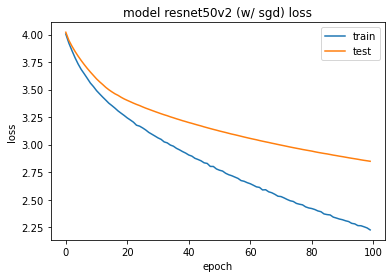

In [ ]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model resnet50v2 (w/ sgd) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

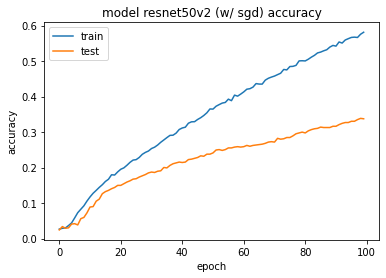

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model resnet50v2 (w/ sgd) accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [ ]:
# WandB – Install the W&B library
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline

!pip install wandb -qq
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,EarlyStopping

!wandb login --relogin
wandb.login() 

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'grid'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric


parameters_dict = {
 'learning-rate':{
        'values': [0.001, 0.003, 0.005]
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 60}
    })


import pprint

pprint.pprint(sweep_config)

{'method': 'grid',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 60},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning-rate': {'values': [0.001, 0.003, 0.005]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="gst000", project="aidl-a02-semester-prjkt")

Create sweep with ID: 35u7ia2t
Sweep URL: https://wandb.ai/gst000/aidl-a02-semester-prjkt/sweeps/35u7ia2t


In [ ]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'learning_rate': 1e-3,
        'dropout': 0.3,
        'fc_layer_size': 128,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture
    cnn4 = Sequential()
    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128,128,3)))
    cnn4.add(BatchNormalization())

    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(config.dropout))

    cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(config.dropout))

    cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(config.dropout))

    cnn4.add(Flatten())

    cnn4.add(Dense(config.fc_layer_size, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(config.dropout))

    cnn4.add(Dense(config.fc_layer_size, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(config.dropout))

    cnn4.add(Dense(40, activation='softmax'))

    batch_size = 128

    save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
    adam = tf.keras.optimizers.Adam(lr=config.learning_rate)

    cnn4.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    cnn4.fit(x_train, y_train, batch_size=batch_size,
              epochs=config.epochs,
              validation_data=(x_test, y_test),
              callbacks=[WandbCallback(validation_data=(x_test, y_test), labels=classes),
                          EarlyStopping(patience=10, restore_best_weights=True), save_model])


In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: a5jk7rda with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	fc_layer_size: 128
wandb: 	learning-rate: 0.005


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/60
67/67 [==============================] - ETA: 0s - loss: 4.1648 - accuracy: 0.0480
Epoch 1: val_loss improved from inf to 5.64046, saving model to best_model.h5
67/67 [==============================] - 33s 447ms/step - loss: 4.1648 - accuracy: 0.0480 - val_loss: 5.6405 - val_accuracy: 0.0324 - _timestamp: 1656720705.0000 - _runtime: 32.0000
Epoch 2/60
67/67 [==============================] - ETA: 0s - loss: 3.7038 - accuracy: 0.0965
Epoch 2: val_loss did not improve from 5.64046
67/67 [==============================] - 15s 225ms/step - loss: 3.7038 - accuracy: 0.0965 - val_loss: 5.9945 - val_accuracy: 0.0230 - _timestamp: 1656720729.0000 - _runtime: 56.0000
Epoch 3/60
67/67 [==============================] - ETA: 0s - loss: 3.5571 - accuracy: 0.1212
Epoch 3: val_loss improved from 5.64046 to 4.96311, saving model to best_model.h5
67/67 [==============================] - 19s 279ms/step - loss: 3.5571 - accuracy: 0.1212 - val_loss: 4.9631 - val_accuracy: 0.0352 - _timestamp: 1

accuracy,▁▁▂▂▃▃▄▄▅▅▆▆▇▇▇▇██████
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▃▄▅▆▇▇█████▇█████
val_loss,▇█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▅▂▃▂▃▂
accuracy,0.85456
best_epoch,11
best_val_loss,2.61587
epoch,21
loss,0.54019
val_accuracy,0.43996


wandb: Agent Starting Run: xl5xiyi3 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 60
wandb: 	fc_layer_size: 256
wandb: 	learning-rate: 0.001
